# Test: NBody15 DynamicalProblem 

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>    

<li><a href="#Initial-value-problem:-NBody15">
             Initial value problem: NBody15</a></li>

<li><a href="#Ode-problem">
             Ode problem</a></li>
             
<li><a href="#DynamicalODEProblem">
             DynamicalODEProblem</a></li>

<li><a href="#2nd-Order-Problem">
             2nd Order Problem</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  

## Loading packages

In [1]:
using Pkg

In [2]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO

<a href="#top">Back to the top</a>

## Computer properties

In [3]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [4]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

2

In [6]:
#plotly()

<a href="#top">Back to the top</a>

## Initial value problem: NBody15

In [6]:
setprecision(BigFloat, 108);
include("../examples/Nbody.jl")
include("../examples/InitialNBody15.jl")

dt=5
t0=0.0
t1=20*dt    #20, 1000.
mysaveat=1  #10
vsaveat=dt

u0,Gm =InitialNBody15(Float64)
tspan=(t0,t1)
prob = ODEProblem(NbodyODE!,u0,tspan,Gm);


u0128,Gm128=InitialNBody15(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128)
(typeof(u0),typeof(Gm),typeof(tspan),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64,3}, Array{Float64,1}, Tuple{Float64,Int64}, Array{BigFloat,3}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Ode problem

### Test solution

In [8]:
setprecision(BigFloat, 256);

sol =solve(prob128,Vern9(),saveat=vsaveat,abstol=1e-20,reltol=1e-20);
test_sol = TestSolution(sol);
#@save "./Data/plei_test_solF64.jld2" sol

#@load "./Data/plei_test_solF64.jld2" sol
#test_sol = TestSolution(sol);
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  4546
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          284
Number of rejected steps:                          0

### IRKGL16

In [9]:
(sol3,iters3,steps3) = solve(prob,IRKGL16(), saveat=mysaveat, reltol=1e-12, abstol=1e-12, adaptive=true,myoutputs=true);
sol3.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  1598
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          11
Number of rejected steps:                          2

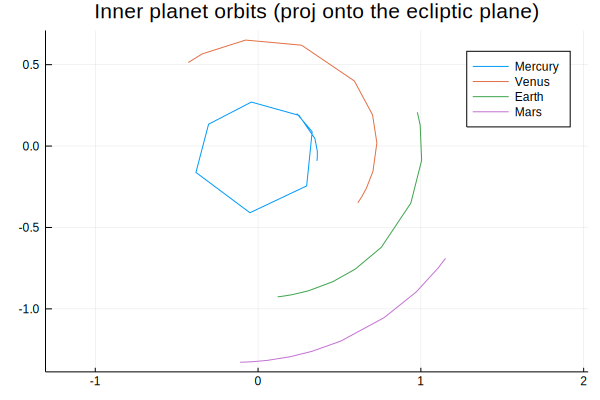

In [11]:
bodylist = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", 
            "Uranus", "Neptune", "Pluto", "Moon", "Ceres", "Pallas", "Vesta", 
             "Iris", "Bamberga"]

ulist0 = sol3.u
tlist0 = sol3.t


pl = plot(title="Inner planet orbits (proj onto the ecliptic plane)", 
          aspect_ratio=1)

for j = 2:5
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end    


plot(pl)

<a href="#top">Back to the top</a>

## DynamicalODEProblem

In [12]:
q0=u0[2,:,:]
v0=u0[1,:,:]
probdyn = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0,v0,tspan,Gm);

In [13]:
sol11 = solve(probdyn,Vern9(),abstol=1e-12,reltol=1e-12);
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  882
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          45
Number of rejected steps:                          10

In [14]:
(sol13,iters13,steps13) = solve(probdyn,IRKGL16(), reltol=1e-12, abstol=1e-12,
                                   adaptive=true,myoutputs=true);
sol13.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  891
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          11
Number of rejected steps:                          2

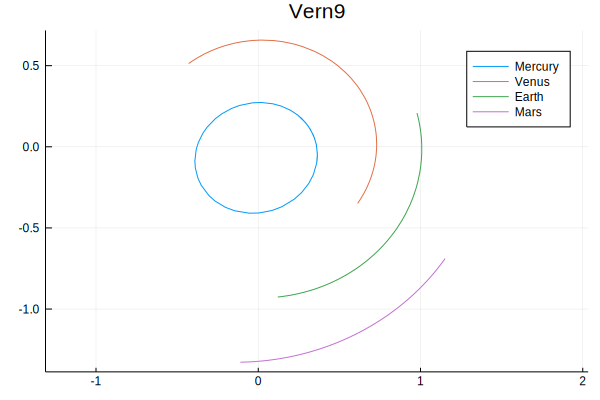

In [18]:
#
# solution in different order !!!!!!
#         

ulist0 = sol11.u
tlist0 = sol11.t


pl = plot(title="Vern9", 
          aspect_ratio=1)

for j = 2:5
# xlist  = map(u->u[2,1,j], ulist0)
# ylist  = map(u->u[2,2,j], ulist0)    
 xlist  = map(u->u[1,1,j], ulist0)
 ylist  = map(u->u[1,2,j], ulist0)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end    


plot(pl)

<a href="#top">Back to the top</a>

## 2nd Order Problem

In [19]:
prob2nd = SecondOrderODEProblem(NbodyODE2nd!,v0,q0,tspan,Gm);

In [20]:
sol21 = solve(prob2nd,Vern9(),abstol=1e-12,reltol=1e-12);
sol21.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  882
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          45
Number of rejected steps:                          10

In [21]:
sol22 =solve(prob2nd,DPRKN12(),abstol=1e-12,reltol=1e-12);
sol22.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  377
Number of function 2 evaluations:                  23
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          21
Number of rejected steps:                          1

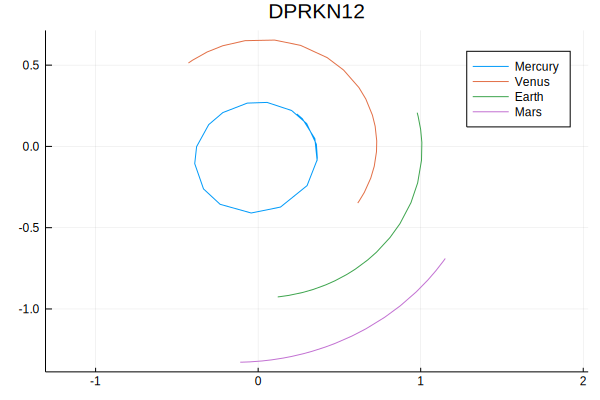

In [22]:
#
# solution correct order !!!!!!
#         

ulist0 = sol22.u
tlist0 = sol22.t


pl = plot(title="DPRKN12", 
          aspect_ratio=1)

for j = 2:5
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)    
 pl = plot!(xlist,ylist, label = bodylist[j])   
end    


plot(pl)

<a href="#top">Back to the top</a>

## Error in energy

In [24]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialNBody15(BigFloat)
E0=NbodyEnergy(u0256,Gm256)

ΔE = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol.u)./E0.-1
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol3.u)./E0.-1
ΔE11 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol11.u)./E0.-1;
ΔE13 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol13.u)./E0.-1;
ΔE21 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol21.u)./E0.-1
ΔE22 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol22.u)./E0.-1;

In [25]:
#Odeproblems
(Float32(maximum(abs.(ΔE))),Float32(maximum(abs.(ΔE3))))

(1.2046719f-23, 2.413979f-16)

In [26]:
#DynamicProblems
(Float32(maximum(abs.(ΔE11))),Float32(maximum(abs.(ΔE13))))

(1.6473425f-15, 3.8592838f-16)

In [27]:
#SecondOrder
(Float32(maximum(abs.(ΔE21))),Float32(maximum(abs.(ΔE22))))

(1.6473425f-15, 1.7227276f-16)

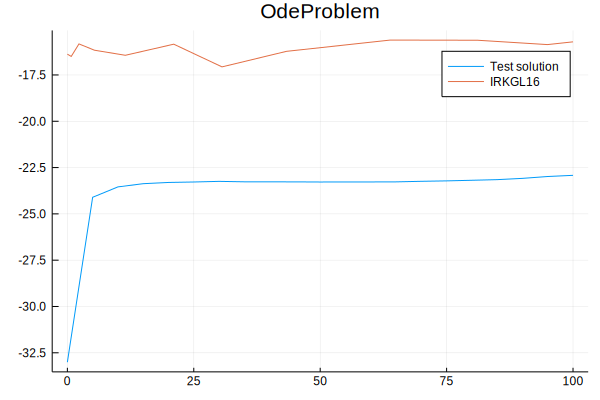

In [28]:
plot(sol.t,log10.(abs.(ΔE)), label="Test solution", title="OdeProblem")
plot!(sol3.t,log10.(abs.(ΔE3)), label="IRKGL16")

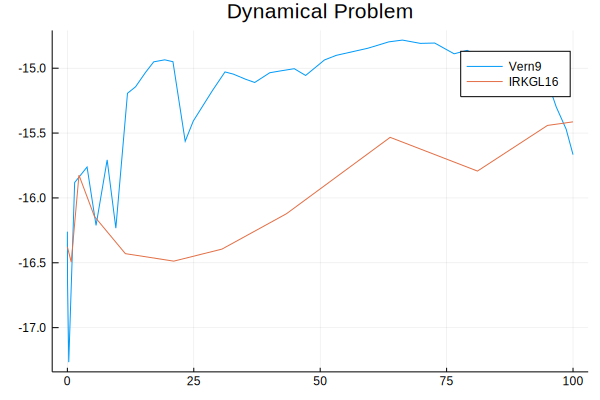

In [29]:
ylimit1=-22
ylimit2=-8
plot(sol11.t,log10.(abs.(ΔE11)), label="Vern9", title="Dynamical Problem")
plot!(sol13.t,log10.(abs.(ΔE13)), label="IRKGL16")

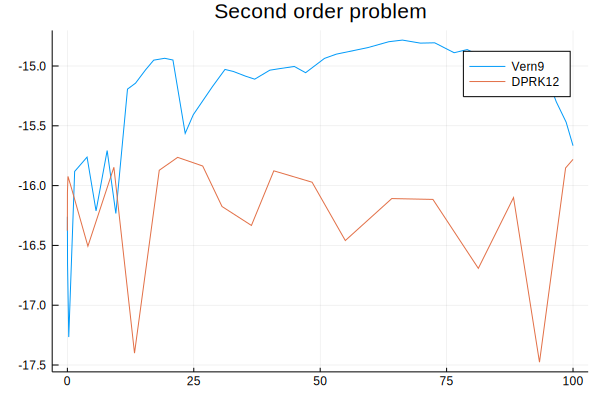

In [30]:
plot(sol21.t,log10.(abs.(ΔE21)), label="Vern9",title="Second order problem")
plot!(sol22.t,log10.(abs.(ΔE22)), label="DPRK12")

<a href="#top">Back to the top</a>